In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
from nltk.translate.bleu_score import corpus_bleu
from nltk.util import ngrams
import numpy as np
from PIL import Image
import configparser

config = configparser.ConfigParser()
config.read("config.ini")

#importing local module 
from models.subclasses import *
# from models.utilities import *
from models.predict import *

In [2]:
units = int(config['config']['units'])
embedding_dim = int(config['config']['embedding_dim'])

In [3]:
val_image_paths, image_path_to_caption = import_files(shuffle= False, method = "val")

val_captions = []
img_name_vector = []
for image_path in val_image_paths:
  caption_list = image_path_to_caption[image_path]
  val_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

100


In [4]:
_, _, _, _, vocabulary, _ = load_dataset()

In [5]:
word_to_index, index_to_word, tokenizer, cap_vector = tokenization(val_captions, max_length, 5000)

In [6]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, len(vocabulary))
_, _, image_features_extract_model = load_models()

In [7]:
img_name_val, cap_val = split_data(img_name_vector, cap_vector ,
                                    image_features_extract_model, 0.2)

100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


In [8]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [178]:
references = []

for i in range(len(img_name_val)):
    references.append(' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[i] if i not in [0]]).split('<start>')[1].split())

In [179]:
list_of_references = []

for i in range(0, len(img_name_val), 4):
    list_of_references.append([references[i:i+4]])

Real Caption: ['a', 'man', 'sleeping', 'with', 'his', 'cat', 'next', 'to', 'him']
Prediction Caption: ['a', 'is', 'chair', 'sink,', 'the', 'vehicles.', 'cat', 'bathroom', 'plane', 'leftover']
BLEU-1: 0.300000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


C:\Users\hazem\AppData\Roaming\Python\Python39\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hazem\AppData\Roaming\Python\Python39\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hazem\AppData\Roaming\Python\Python39\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

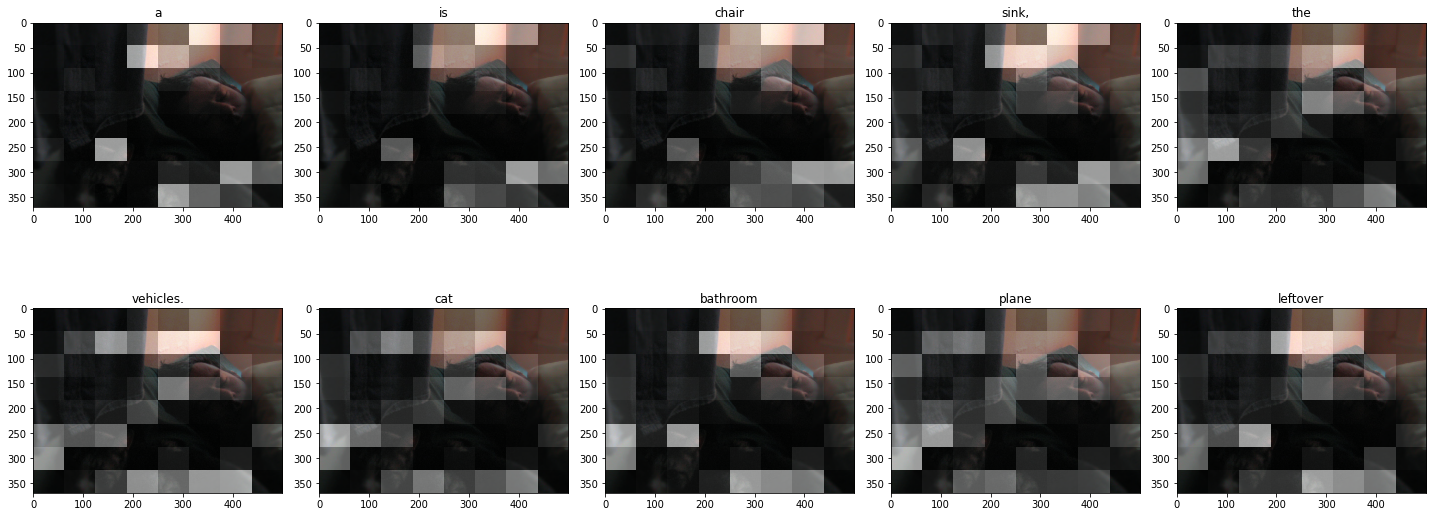

In [189]:
# captions on the test set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
num = 0

image = img_name_val[num]
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[rid] if i not in [0]]).split()

result, attention_plot = evaluate(image, encoder, decoder, image_features_extract_model,
                                    word_to_index, index_to_word)

if result[-1] == "<end>":
    result.remove("<end>")
# if real_caption[0] == "<start>":
#     real_caption.remove("<start>")


list_of_hypotheses = [result]

print('Real Caption:', references[int(num/4)])
print('Prediction Caption:', result)
print('BLEU-1: %f' % corpus_bleu(list_of_references[num], list_of_hypotheses, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(list_of_references[num], list_of_hypotheses, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(list_of_references[num], list_of_hypotheses, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(list_of_references[num], list_of_hypotheses, weights=(0.25, 0.25, 0.25, 0.25)))
plot_attention(image, result, attention_plot)